It's been a year and a half since I blogged about why Julia is an awesome programming language for data scientists. I wanted to follow up the post by drawing attention to the role __performance__ can have, especially when working interactively. It might not be immediately clear exactly how much is being given up by running a language like R or Python for mathematics and scientific computation. Moreover, the syntax of Julia, especially with support for UTF8, is really a pleasure when doing data science.

I'll exemplify on my laptop, a Dell XPS with a Core i7-7700HQ @ 2.80GHz

The example is a golden oldie, namely the [Escape Time Algorithm](https://en.wikipedia.org/wiki/Mandelbrot_set#Escape_time_algorithm) for rendering the [Julia set](https://en.wikipedia.org/wiki/Julia_set) using the quadratic polynomial: $f_c(z)=z^2+c$ and the complex parameter $(\varphi-2) + (\varphi-1)i$

Let's GO!

# JULIA 0.6.0

In [2]:
detail = 1000; h = 6000; w = 6000
bitmap = zeros(h,w)
c = (φ-2) + (φ-1)im

function fractal(z, c, lod)
    for i in 1 : lod
        (abs(z) > 2) ? (return i) : (z = z^2 + c) 
    end
    return lod
end

function generate(bitmap, w, h, c, lod)
    for x in 1:w, y in 1:h
        z = (3*(x-w/2)/w) + (3*(y-h/2)/h)im
        bitmap[y,x] = fractal(z, c, lod) / lod
    end
    return bitmap
end

tic()
image = generate(bitmap, w, h, c, detail)
toc()

elapsed time: 4.523818 seconds


4.523818

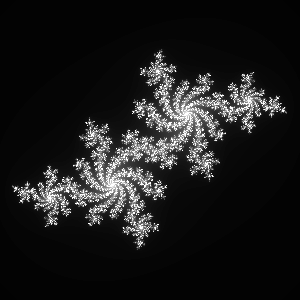

In [6]:
using Colors, Images
Array{Gray24}(image)

Let's try a tweak just because it's so easy, namely parallelizing the for loop.

In [3]:
function generate(bitmap, w, h, c, lod)
    Threads.@threads for x in 1:w
        for y in 1:h
            z = (3*(x-w/2)/w) + (3*(y-h/2)/h)im
            bitmap[y,x] = fractal(z, c, lod) / lod
        end
    end
    return bitmap
end

tic() 
image = generate(bitmap, w, h, c, detail)
toc()

elapsed time: 1.490306 seconds


1.490306

The algorithm finished in a bit over 1 second. Pretty fast!

Let's try the same thing in Python.

# PYTHON 3.5.2

In [1]:
import time
import numpy

detail = 1000; h = 6000; w = 6000
bitmap = numpy.zeros((h,w))
c = -0.3819660112501051 + 0.6180339887498949j

def fractal(z, c, lod):
    for i in range(lod):
        if abs(z) > 2:
            return i+1
        z = z * z + c
    return lod;
        
def generate(bitmap, w, h, c, lod):
    for x, y in numpy.ndindex(bitmap.shape):
        z = complex(3*(x+1-w/2)/w, 3*(y+1-h/2)/h)
        bitmap[y,x] = fractal(z, c, lod) / lod           
    return bitmap;
                
t1 = time.time()
image = generate(bitmap, w, h, c, detail)
t0 = time.time()
t0-t1

179.79193115234375

About 3 minutes. Python was ~40x slower than single-threaded Julia. Hmm...

Let's try the same thing in R.

# R 3.2.3

In [1]:
detail <- 1000; h <- 6000; w <- 6000
bitmap <- matrix(0, h, w)
c <- complex(real=-0.3819660112501051,imaginary=0.6180339887498949)

fractal <- function(z, c, max) {
    for (i in 1:max) {
        if (Mod(z) > 2) return(i)
        z <- z^2 + c
    }
    return(max)
}

generate <- function(bitmap, w, h, c, lod) {
    for (x in 1:w) { 
        for (y in 1:h) {
            z <- complex(real=(3*(x-w/2)/w), imaginary=(3*(y-h/2)/h))
            bitmap[x,y] <- fractal(z, c, lod) / lod
        }
    }
    return(bitmap)
}
    
t0 <- Sys.time()
bitmap <- generate(bitmap, w, h, c, detail)
t1 <- Sys.time()
print(t1-t0)   

Time difference of 8.692687 mins


I laughed when I saw a question on Quora asking what statisticians do while their code is running. Now I understand. The R code was over ~120x slower!

I'd like to nip a small intejection right at the bud. We all know that to get good performance in R (and other interpreted languages) the ~~code~~ entire algorithm needs to be refactored so that it's "vectorized". That way hot code can be offloaded to a faster language (like BLAS functions written in Fortran) without having to make an expensive function call for every element of a data set. The downside is that it's not always possible, and when it is possible, it can force you to express algorithms in a very contrived way.

But, to be fair, let's try the R version again in vector form and watch the performance improve:

In [9]:
detail <- 1000; h <- 6000; w <- 6000
z <- matrix(0.0, h, w)
k <- matrix(0.0, h, w)
x <- seq(0, h)
y <- seq(0, w)
t0 <- Sys.time()
c <- outer(x*-0.3819660112501051,y*0.6180339887498949i,FUN="+")
for (rep in 1:detail) { 
    index <- which(Mod(z) < 2)
    z[index] <- z[index]^2 + c[index]
    k[index] <- k[index] + 1
}
t1 <- Sys.time()
print(t1-t0)

Time difference of 12.24876 mins


12 minutes!!? It was supposed to be faster! That stinks. Testing this R code on a smaller 300x300 matrix confirms that it is actually quite a bit faster than the non-vectorized version. But given a 6000x6000 matrix, it ends up being __~2x slower__ and uses __5x more memory__. Oh well. :(

Obviously, one could achieve optimal performance on the fractal algorithm by hand-rolling it in bare assembly language, but I think most data scientists have more interesting things to do. If you can write code that looks great, with less effort, and have great performance all at once, why wouldn't you? Coincidentally, it's very easy to analyze the assembly code of inner loops in Julia, but that's another blog post. ;-) 

Happy hacking!

# JULIA 0.6.0

In [4]:
@code_native fractal(1im,1im,1)

	.text
Filename: In[2]
	pushq	%rbp
	movq	%rsp, %rbp
	pushq	%r15
	pushq	%r14
	pushq	%r13
	pushq	%r12
	pushq	%rbx
	pushq	%rax
	movq	%rdx, %r14
	movq	%rsi, %r15
Source line: 6
	testq	%r14, %r14
	jle	L135
	movq	(%rdi), %r12
	movq	8(%rdi), %rbx
	xorl	%r13d, %r13d
	movabsq	$139943019581136, %rax  # imm = 0x7F4705F88ED0
	vmovsd	(%rax), %xmm0           # xmm0 = mem[0],zero
	vmovsd	%xmm0, -48(%rbp)
	nopw	%cs:(%rax,%rax)
Source line: 7
L64:
	movq	%r12, %rdi
	movq	%rbx, %rsi
	movabsq	$hypot, %rax
	callq	*%rax
	vucomisd	-48(%rbp), %xmm0
	ja	L128
	movq	%rbx, %rax
	imulq	%r12, %rbx
	imulq	%r12, %r12
	imulq	%rax, %rax
	subq	%rax, %r12
	addq	%rbx, %rbx
	addq	(%r15), %r12
	addq	8(%r15), %rbx
Source line: 6
	addq	$1, %r13
	cmpq	%r13, %r14
	jne	L64
	jmp	L135
Source line: 7
L128:
	addq	$1, %r13
	movq	%r13, %r14
Source line: 9
L135:
	movq	%r14, %rax
	addq	$8, %rsp
	popq	%rbx
	popq	%r12
	popq	%r13
	popq	%r14
	popq	%r15
	popq	%rbp
	retq
	nopl	(%rax)
